<a href="https://colab.research.google.com/github/bhuvnk/END2.0/blob/main/Session%207%20-%20Second%20Hands-on%20Encoder-Decoder/Part1_SST_Classification/SST_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !nvidia-smi

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

import torch, torchtext
from torchtext.legacy import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Manual Seed
SEED = 69
torch.manual_seed(SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Get the Data

In [ ]:
!wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
!unzip -q 'stanfordSentimentTreebank.zip'

--2021-06-25 10:52:52--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2021-06-25 10:52:52--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr 100%[===================>]   6.08M  7.30MB/s    in 0.8s    

2021-06-25 10:52:53 (7.30 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [6372817/6372817]



In [ ]:
PATH = '/content/stanfordSentimentTreebank'

# Data Preprocessing

We have 3 datasets:

1. `datasetSentences.txt` : just containing the sentences(subset of phrases in `Dictionary.text`
2. `Dictionary.text` : a mapping of a lot of `sentences`(called phrases` and their `phrase ids`
3. `sentiment_labels.txt` has sentiment values for `phrase ids`

Basically Labels are actually mapped to the Phrases and not directly to sentences; we will need to map labels to sentences but first getting `phrase ids` for each sentences.


Combining `datasetSentences.txt`  and `dictionary.txt` will give phrase id's for the sentence data; let's call it: `sent_phrase_df`

Merging `sent_phrase_df` with `sentiment_label` will give us sentiment values for each sentence. : `final_df`

**Steps to follow**

1. Get `phrase ids` for each sentence by inner join: {`Sent_df` and `dictionary`} | Call: `sent_phrase_df`
2. Get sentiment values for each sentence based on `phrase ids` by left join: {`sent_phrase_df` and `sentiment_labels`} 

## Sentences + Dictionary for Phrase Ids






In [ ]:
# Sentences contains index of the sentence and the text 
sent_df = pd.read_csv(PATH+'/datasetSentences.txt', sep = '\t')
sent_df.head()

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha..."


In [ ]:
sent_df.shape


(11855, 2)

In [ ]:
# Dictionary maps the phrase texts to the phrase id
dict_df = pd.read_csv(PATH+'/dictionary.txt', sep = '|', names =['phrase', 'phrase ids'])
dict_df.head()

,phrase,phrase ids
0,!,0
1,! ',22935
2,! '',18235
3,! Alas,179257
4,! Brilliant,22936


In [ ]:
dict_df.shape

(239232, 2)

### get phrase ids of the Sentences with dictionary : on common values

In [ ]:
sent_phrase_df = pd.merge(sent_df, dict_df, how= 'inner', left_on='sentence', right_on='phrase')
sent_phrase_df.drop(columns=["phrase"], inplace=True)
sent_phrase_df.head()


,sentence_index,sentence,phrase ids
0,1,The Rock is destined to be the 21st Century 's...,226166
1,2,The gorgeously elaborate continuation of `` Th...,226300
2,3,Effective but too-tepid biopic,13995
3,4,If you sometimes like to go to the movies to h...,14123
4,5,"Emerges as something rare , an issue movie tha...",13999


In [ ]:
sent_phrase_df.shape

(11286, 3)

Basically we have phrase id's for `11286` sentences out of `11855` sentences.

## Sentiment Labels

`sentiment_labels.txt` has sentiment values for all phrases.

In [ ]:
# 
label_df = pd.read_csv(PATH+'/sentiment_labels.txt', sep = '|')
label_df.head()

,phrase ids,sentiment values
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708


In [ ]:
label_df.shape

(239232, 2)

### merge sentiment with sentences with the phrase ids

In [ ]:
final_df = pd.merge(sent_phrase_df, label_df , how = 'left', on = 'phrase ids')
final_df.head()

,sentence_index,sentence,phrase ids,sentiment values
0,1,The Rock is destined to be the 21st Century 's...,226166,0.69444
1,2,The gorgeously elaborate continuation of `` Th...,226300,0.83333
2,3,Effective but too-tepid biopic,13995,0.51389
3,4,If you sometimes like to go to the movies to h...,14123,0.73611
4,5,"Emerges as something rare , an issue movie tha...",13999,0.86111


In [ ]:
final_df.shape

(11286, 4)

## Convert floating-point labels into 5 classes (0-0.2, 0.2-0.4, 0.4-0.6, 0.6-0.8, 0.8-1.0)

In [ ]:
final_df['label'] = pd.cut(final_df['sentiment values'], 5, labels=False).astype(int)
final_df.head()

,sentence_index,sentence,phrase ids,sentiment values,label
0,1,The Rock is destined to be the 21st Century 's...,226166,0.69444,3
1,2,The gorgeously elaborate continuation of `` Th...,226300,0.83333,4
2,3,Effective but too-tepid biopic,13995,0.51389,2
3,4,If you sometimes like to go to the movies to h...,14123,0.73611,3
4,5,"Emerges as something rare , an issue movie tha...",13999,0.86111,4


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11286 entries, 0 to 11285
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sentence_index    11286 non-null  int64  
 1   sentence          11286 non-null  object 
 2   phrase ids        11286 non-null  int64  
 3   sentiment values  11286 non-null  float64
 4   label             11286 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 529.0+ KB


Looks clean

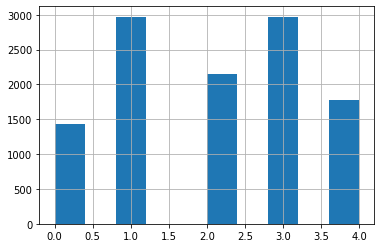

In [ ]:
final_df['label'].hist()

## **Create Datasets**

In [ ]:
# Define Sentences and Label fields
Sentence = data.Field(sequential = True,
                      tokenize = 'spacy',
                      batch_first = True,
                      include_lengths = True)

Label = data.LabelField(tokenize ='spacy',
                        is_target = True,
                        batch_first = True,
                        sequential = False)

# fields variable
fields = [('sentence', Sentence),('label',Label)]

# Create example variable using torch library
example = [data.Example.fromlist([final_df.sentence.iloc[i], final_df.label.iloc[i]], fields) for i in range(final_df.shape[0])] 

# Compile all the training examples
stanTreeDataset = data.Dataset(example, fields)

## 70/30 train-test Split 

In [ ]:
(train_set, valid_set) = stanTreeDataset.split(split_ratio=[0.70, 0.30],
                                      random_state=random.seed(SEED))

Sentence.build_vocab(train_set)
Label.build_vocab(train_set)

In [ ]:
(len(train_set), len(valid_set))

(7900, 3386)

In [ ]:
print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  16409
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 7435), (',', 6461), ('the', 5418), ('and', 4024), ('a', 4005), ('of', 4004), ('to', 2800), ('-', 2533), ('is', 2341), ("'s", 2268)]
Labels :  defaultdict(None, {3: 0, 1: 1, 2: 2, 4: 3, 0: 4})


## Create Iterator variables

In [ ]:
train_iterator, valid_iterator = data.BucketIterator.splits((train_set, valid_set),
                                                          batch_size = 32, 
                                                          sort_key = lambda x: len(x.sentence),
                                                          sort_within_batch=True,
                                                          device = device)

In [ ]:
next(iter(train_iterator))


[torchtext.legacy.data.batch.Batch of size 32]
	[.sentence]:('[torch.cuda.LongTensor of size 32x22 (GPU 0)]', '[torch.cuda.LongTensor of size 32 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

# **Model Architecture**

In [ ]:
class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers,
                           bidirectional=True, 
                           dropout=dropout,
                           batch_first=True)
        self.dropout = nn.Dropout(dropout)
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.dropout(self.embedding(text))
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [ ]:
# Define hyperparameters
size_of_vocab = len(Sentence.vocab)
embedding_dim = 256
num_hidden_nodes = 128
num_output_nodes = len(final_df.label.unique())
num_layers = 2
dropout = 0.5

# Instantiate the model
model = classifier(size_of_vocab,
                   embedding_dim,
                   num_hidden_nodes,
                   num_output_nodes,
                   num_layers,
                   dropout = dropout)

In [ ]:
print(model)

# No. of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(16409, 256)
  (encoder): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
The model has 4,991,877 trainable parameters


In [ ]:
# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

# **Training & Evaluation Functions**

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()  

        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# **Model Training**

In [ ]:
N_EPOCHS = 50
best_valid_loss = float('inf')

train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)

    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_accuracy.append(train_acc)
    train_losses.append(train_loss)

    valid_accuracy.append(valid_acc)
    valid_losses.append(valid_loss)

    print(f'\tEpoch: {epoch} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Epoch: 0 | Train Loss: 1.586 | Train Acc: 25.94%
	 Val. Loss: 1.577 |  Val. Acc: 26.99% 

	Epoch: 1 | Train Loss: 1.576 | Train Acc: 27.42%
	 Val. Loss: 1.575 |  Val. Acc: 27.58% 

	Epoch: 2 | Train Loss: 1.573 | Train Acc: 28.85%
	 Val. Loss: 1.574 |  Val. Acc: 27.58% 

	Epoch: 3 | Train Loss: 1.566 | Train Acc: 30.80%
	 Val. Loss: 1.573 |  Val. Acc: 29.40% 

	Epoch: 4 | Train Loss: 1.551 | Train Acc: 33.74%
	 Val. Loss: 1.568 |  Val. Acc: 31.35% 

	Epoch: 5 | Train Loss: 1.537 | Train Acc: 34.97%
	 Val. Loss: 1.565 |  Val. Acc: 32.45% 

	Epoch: 6 | Train Loss: 1.527 | Train Acc: 36.11%
	 Val. Loss: 1.569 |  Val. Acc: 32.50% 

	Epoch: 7 | Train Loss: 1.518 | Train Acc: 37.16%
	 Val. Loss: 1.550 |  Val. Acc: 34.11% 

	Epoch: 8 | Train Loss: 1.508 | Train Acc: 38.06%
	 Val. Loss: 1.549 |  Val. Acc: 34.47% 

	Epoch: 9 | Train Loss: 1.500 | Train Acc: 39.24%
	 Val. Loss: 1.553 |  Val. Acc: 34.17% 

	Epoch: 10 | Train Loss: 1.491 | Train Acc: 39.94%
	 Val. Loss: 1.539 |  Val. Acc: 35.15% 

# Training plots

Text(0.5, 1.0, 'Loss')

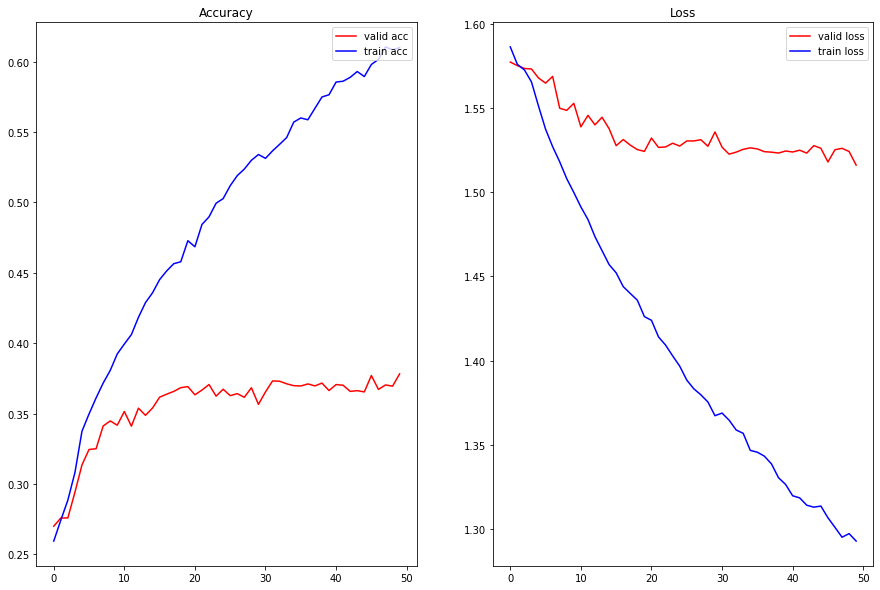

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))

axs[0].plot(valid_accuracy, '-r', label='valid acc')
axs[0].plot(train_accuracy, '-b', label='train acc')
axs[0].legend(loc = "upper right")
axs[0].set_title("Accuracy")

axs[1].plot(valid_losses, 'r', label='valid loss')
axs[1].plot(train_losses, 'b', label='train loss')
axs[1].legend(loc = "upper right")
axs[1].set_title("Loss")

# Making a few Sample predictions

In [ ]:
# load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

# inference 

nlp = spacy.load('en')

def classify_sentence(sentence):
        
    # tokenize the sentence 
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    #return categories[pred.item()]
    return pred.item()

In [ ]:
label_dict = {0 : 'very negative',
              1 : 'negative',
              2 : 'neutral',
              3 : 'positive',
              4 : 'very positive'}

# Print 10 samples from the test dataset

for i in range(10):
  print("Sentence : ", ' '.join(valid_set.examples[i].sentence))
  pred = classify_sentence(' '.join(valid_set.examples[i].sentence))
  print(f"Predicted : {label_dict[pred]}")
  print(f"Target : {label_dict[valid_set.examples[i].label]}\n")

Sentence :  The pleasures that it does afford may be enough to keep many moviegoers occupied amidst some of the more serious - minded concerns of other year - end movies .
Predicted : neutral
Target : positive

Sentence :  The power of this script , and the performances that come with it , is that the whole damned thing did n't get our moral hackles up .
Predicted : very negative
Target : neutral

Sentence :  The isolated moments of creative insanity finally are lost in the thin soup of canned humor .
Predicted : very negative
Target : neutral

Sentence :  Poetry in motion captured on film .
Predicted : positive
Target : very positive

Sentence :  I like the new footage and still love the old stuff .
Predicted : very negative
Target : very positive

Sentence :  Nemesis suffers from a paunchy midsection , several plodding action sequences and a wickedly undramatic central theme .
Predicted : negative
Target : negative

Sentence :  Few of the increasingly far - fetched events that first 